In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import functools
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.utils
from torch.autograd import Function
from torch.utils.data import Dataset
from torchvision.io import read_image

In [2]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
#device='cpu'

In [3]:
class lung_dataset(Dataset):
    def __init__(self, data_path, transform, train_test = 'train'):
        self.im_path = data_path + '/images/images/' #Path to images
        self.meta_csv = pd.read_csv(data_path + '/metadata_{}.csv'.format(train_test)) #Path to metadata
        self.transform = transform #Predefined transforms

        #Get dictionaries to map disease classes to numbers and vice versa
        self.label_to_dis_class = self.meta_csv['Finding Labels'].drop_duplicates().reset_index().to_dict()['Finding Labels']
        self.dis_class_to_label = dict((v,k) for k,v in self.label_to_dis_class.items())
        
        #Get dict to map genders to numbers and vice versa
        self.label_to_gender = self.meta_csv['Patient Gender'].drop_duplicates().reset_index().to_dict()['Patient Gender']
        self.gender_to_label = dict((v,k) for k,v in self.label_to_gender.items())

    def __len__(self):
        return len(self.meta_csv)
        #return 50000

    def __getitem__(self, idx):
        im_data = self.meta_csv.iloc[idx]

        im = Image.open(self.im_path + im_data['Image Index']).convert("L")
        im = self.transform(im)

        label_dis = self.dis_class_to_label[im_data['Finding Labels']]
        
        label_gen = self.gender_to_label[im_data['Patient Gender']]

        return im, label_dis, label_gen

In [4]:
#train_transform = T.Compose([T.ToTensor()])
train_transform = T.Compose([
        T.Resize(224),
        #T.RandomCrop(224),
        #T.RandomHorizontalFlip(),
        T.ToTensor(),
        #normalize
])

#Dataset train_test can be: 'train' or 'test'
#Val data comes from splitting train set
dataset = lung_dataset('./CXR8', train_transform, 'train')

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = dataloader.DataLoader(train_dataset, shuffle = True, batch_size = 32)
test_loader = dataloader.DataLoader(val_dataset, shuffle = False, batch_size = 32)

print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))

73471
58776
14695


Disease Label: 1  Class:  No Finding
Disease Label: 1  Class:  F


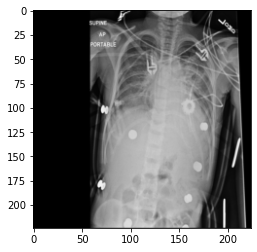

In [5]:
dataiter = iter(train_loader)

images, dis_labels, gen_labels = dataiter.next()

plt.imshow(images[0].permute(1, 2, 0)/255, cmap='gray')
print("Disease Label:", dis_labels[0].item(), " Class: ", dataset.label_to_dis_class[dis_labels[0].item()])
print("Disease Label:", gen_labels[0].item(), " Class: ", dataset.label_to_gender[gen_labels[0].item()])

In [6]:
def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

In [7]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

In [8]:
class GenderClassification(nn.Module):

    def __init__(self):

        super(GenderClassification, self).__init__()
        print("Build a GenderClassification Model")

        self.base_network = models.resnet18(pretrained = False)
        print('Load weights from Resnet18 done')

        self.finalLayer = nn.Linear(self.base_network.fc.in_features, 2)

    def forward(self, image):
        x = self.base_network.conv1(image)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        x = self.base_network.maxpool(x)

        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)

        x = self.base_network.avgpool(x)
        image_features = x.view(x.size(0), -1)

        preds = self.finalLayer(image_features)

        return preds
        

In [9]:
model = GenderClassification().to(device)

criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay = 1e-5)

totalloss_log = []
totalacc_log = []


Build a GenderClassification Model
Load weights from Resnet18 done


In [ ]:
model.train()

best_acc = 0

for epoch in range(5):
    
    correct_predictions = 0
    total_predictions = 0
    
    for batch_idx, (im, label_dis, label_gen) in tqdm(enumerate(train_loader)):
        
        im = torch.cat((im, im, im), axis=1)
        
        images = im.to(device)
        targets = label_dis.to(device)
        genders = label_gen.to(device)
        
        model_preds = model(images)
        
        task_loss = criterion(model_preds, genders)
    
        loss = task_loss
        totalloss_log.append(loss.item())
        
        _, predicted = torch.max(model_preds, 1)
        correct_predictions += (predicted == targets.to(device)).sum().item()
        total_predictions += targets.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    acc = correct_predictions/total_predictions
    if acc > best_acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        
    totalacc_log.append(correct_predictions/total_predictions)
    
    
        

1837it [14:11,  2.16it/s]
1687it [13:14,  2.14it/s]

In [ ]:
torch.save(best_model.state_dict(), './gender_pred_model_res18.pt')

In [ ]:
plt.plot(totalloss_log)
plt.show()
plt.plot(totalacc_log)
plt.show()